<font size="5">**Alberi di classificazione / regressione (CART)**</font><br>

> (c) 2025 Antonio Piemontese

L'acronimo CART sta per: **C**lassification **A**nd **R**egression **T**rees. Gli alberi, infatti, possono prevedere sia etichette categoriche (Classificazione) che numeri (Regressione).

---
Il presente notebook <u>non</u> si limita a spiegare l'algorimo degli alberi decisionali (con *scikit-learn*), ma imposta una **framework** di lavoro che **riuseremo** per i prossimi algoritmi con scikit-learn.

---

# La rilevazione dell'ambiente
**Il presente notebook funziona sia in Jupyter Notebook che Google Colab**.
A questo scopo, per garantire la compatibilità di alcune celle di codice con entrambi gli ambienti indicati, **rileviamo l'ambiente di esecuzione del notebook** (Jupyter oppure Google Colab): la seguente cella imposta una **variabile booleana `IN_COLAB`** che sarà poi **testata** da alcune celle del notebook (in particolare quelle di visualizzazione di immagini e PDF) per personalizzarne il comportamento a seconda dell'ambiente di esecuzione dell'ambiente rilevato.

In [19]:
# impostazione del TOGGLE BINARIO:
try:
    import google.colab                      # package disponibile SOLO in Google Colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Siamo in Colab:", IN_COLAB)

Siamo in Colab: False


# Immagini e PDF

Questo notebook incorpora i seguenti PDF:
- `Decision Tree in Python using scikit-learn_ the complete guide with code _ Towards AI`
- `Grid Search vs. Random Search vs. Bayesian Optimization`

e le seguenti immagini PNG:
- `tree_overfit.png`
- `decision_tree_post.png`
- `decision_tree_nardini.png`
- `dsfb_0303.png`
- `encoding_right.png`
- `data_partitioning.png`
- `CV_innestata.png`
- `CV_non_innestata.png`
- `EDA.png`
- `cart_example.png`
- `struttura_german_credit.png`
  
Sia le immagini che i PDF devono essere preliminarmente caricati nella **session storage** (vedi più avanti).

# Il package dmba

Google Colab fornisce moltissimi package già installati nella Macchina Virtuale (di Colab). Il seguente package, relativo ad un importante libro sul ML con Python, vedi [qui](https://www.amazon.it/Machine-Learning-Business-Analytics-Applications/dp/1394286791/ref=sr_1_6?__mk_it_IT=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=2TM4LWT52KN76&dib=eyJ2IjoiMSJ9.XTS2t2ES8GzXyxa3RPTOLrO0fQBCTEB2d2RRlsdmhQSlM3epyJIQyKcqIeuV-BS5WkGOqv2V5DB1THAaKRaGafJMvSugiW-pkHn4qVh0h9PKZzE2tuNUb-IygC5fVITVxs-e3XfBFllGG9W7NhKWNpXUVpWe-scd7Ejkg1DSn0ng__0-2Qze_xhTWJ53Wnh4.oyCBHIAnNhg3THoB_7lyczJ_-yMbmI7b16Yu6ThbUzI&dib_tag=se&keywords=data+mining+for+business+applications+shmueli&qid=1760085336&s=books&sprefix=data+mining+for+business+applications+shmueli%2Cstripbooks%2C59&sr=1-6), non è pre-installato da Google Colab e deve quindi essere installato, in uno di questi tre modi:
- direttamente dal notebook nel seguente modo (l'unico modo in Google Colab perchè esso NON rende disponibile una CLI)
- aprendo un terminale (CLI=Client Line Interface) di tipo **Anaconda Prompt** (disponibile dal menù Windows se Anaconda è stato installato, insieme all'altra app **Anaconda Navigator**) e digitando *pip install <nome-package>*.<br>
Questa seconda modalità (possibile in Anaconda / Jupyter Notebook) permette di controllare meglio il processo di installazione, che può chiedere delle conferme oppure segnalare delle cose.
- se non si dispone di un anaconda prompt (perchè Anaconda non è stato installato) e si sta sviluppando il codice con un'altra IDE (VSC), occorre verificare la directory del *pip.exe* tramite il comando *where pip* e quindi mettere tale directory nella variabile di ambiente utente (di Windows) denominata *Path*, editandola con il tasto *Modifica* e creando una nuova voce ad hoc con il tasto *Nuovo*.

In [2]:
!pip install dmba

Come si verifica se l'ìnstallazione è andata a buon fine?<br>
L'output della celle precedente deve riportare la scritta *Successully installed <nome-package)* e non ci devono essere stati errori. I warning sono accettabili.<br>
Attenzione: la scritta "Requirement already satisfied" significa solo che il package richiesto, oppure una sua dipendenza, era già installato e dunque NON rappresenta assolutamente un problema.

# Importazione dei package

Ora dobbiamo importare, cioè caricare in memoria, i package necessari a questo notebook. Esistono due prassi nella comunità Python:
- importare i package al momento nel quale servono (per risparmiare memoria)
- oppure tutti all'inizio (più comodo e chiaro)

In [3]:
# alcuni di questi import potrebbero essere inutili per questo notebook; toglierli perchè consumano memoria.

import pandas as pd                             # per gestire i dataframe e le serie
import numpy as np                              # per calcoli numerici

# per plot:
import matplotlib as plt                        # per fare plot (il più utilizzato)
from matplotlib.colors import ListedColormap
from distutils.version import LooseVersion      # to check recent matplotlib compatibility
import seaborn as sns                           # un altro package per fare plot avanzati
import plotly.express as px                     # package di grafica avanzata

# libreria di ML scikit-learn:
import sklearn
from sklearn import datasets                                             # alcuni dataset già pronti (dataset giocattolo, ad esempio iris)
from sklearn.model_selection import train_test_split                     # importante funzione per suddividere il dataset in training e test
from sklearn.preprocessing import StandardScaler                         # classe per standardizzare i dati
from sklearn import tree                                                 # una sottolibreria di scikit-learn per gli alberi decisionali
from sklearn.tree import DecisionTreeClassifier                          # la classe di classificazione tramite albero decisionale
from sklearn.tree import DecisionTreeRegressor                           # la classe per la regressione tramite albero decisionale
from sklearn.tree import plot_tree                                       # la funzione per la visualizzazione dell'albero
from sklearn.metrics import confusion_matrix,accuracy_score              # metriche di valutazione delle previsioni
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV # 3 package per la cross-validazione

import dmba                                    # prima fare (da terminale): pip install dmba
                                               # da ottobre 2024 questo package fa parte della distribuzione Anaconda e quindi
                                               # non è più necessario installarlo (se si usa Anaconda)

from dmba import classificationSummary, regressionSummary, plotDecisionTree # ottime funzioni di sintesi e di plot alberi

# package necessari per la VISUALIZZAZIONE delle IMMAGINI e dei PDF (necessari sia in JN che in Colab):
# IPython.display è la cassetta degli attrezzi di Jupyter/Colab per mostrare contenuti ricchi (immagini, HTML, iframe, audio, video, ecc.) 
# direttamente nell’output della cella. Per maggiori info al riguardo vedi il notebook di introduzione a Google Colab.
from IPython.display import Image, display,IFrame   


import os                                           # necessario a Google Colab per vedere da una cella codice
                                                    # i contenuti del 'content'

if IN_COLAB:
  from google.colab import files

          

#-------------------------------------------------

# quando NON si conosce ancora bene il contenuto di un notebook è bene lasciare attiva la visualizzazione dei warning (spesso relativi
# a metodi/funzioni oppure argomenti degli stessi DEPRECATI).
# DOPO esserci familiarizzati con il notebook possiamo anche DISATTIVARE la visualizzazione dei warning nel seguente modo:

# import warnings
# warnings.filterwarnings("ignore")

# Gli alberi

**Cosa sono gli alberi?**
* Gli alberi sono un ottimo algoritmi di ML per capire i pattern tra dati, cioèad esempio le relazioni tra predittori e risposta (explainable AI): per contro, prevedono maluccio.
* Gli alberi sono anche un ottimo algoritmo da spiegare agli utenti
* Simulano il processo decisionale umano (diagnosi mediche, decisioni di finanziamento, ecc.
* Sono un algoritmo parametrico (perchè produce un modello, che è l'albero, visualizzabile anche con *p* alto) e non-lineare (nella struttura delle regioni create dal decision boundary).
* Creano oggetti strutturati (Wikipedia EN).
* Non richiedono (necessariamente) la standardizzazione preliminare dei dati (a differenza del knn od altri metodi) perchè NON fanno uso del concetto di distanza.

L'albero simula un tipico **processo decisionale**, ad esempio di un medico durante una visita. Vediamo un **oggetto di tipo albero** (NON prodotto in questo caso da un algoritmo di ML):

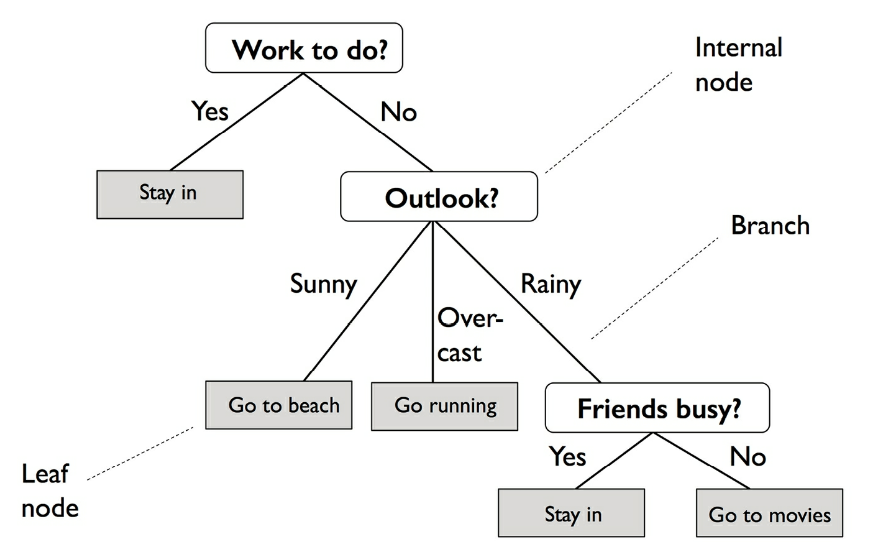

In [4]:
Image('cart_example.png') if IN_COLAB else display(Image(filename='cart_example.png'))

La ricerca ha scoperto che gli alberi **BINARI** funzionano meglio di quelli *ternari*, come quello sopra visualizzato. I due algoritmi *scikit-learn* che useremo *DecisionTreeClassifier* e *DecisionTreeRegressor* implementano alberi binari.

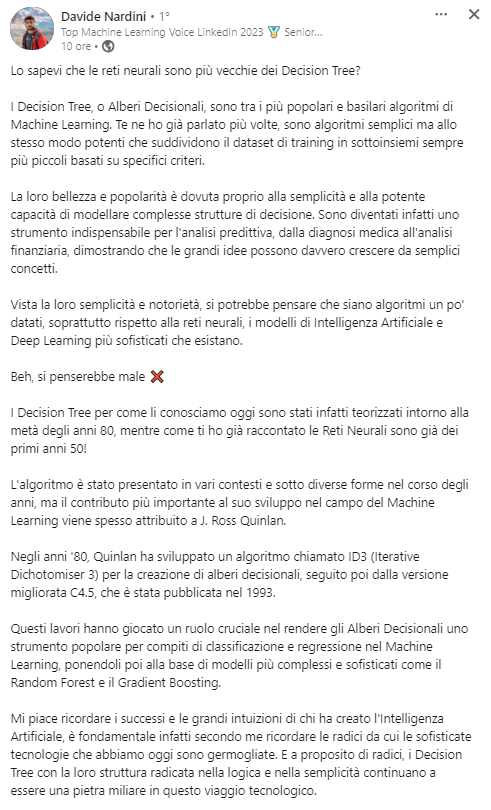

In [17]:
Image('decision_tree_nardini.png') if IN_COLAB else display(Image(filename='decision_tree_nardini.png'))

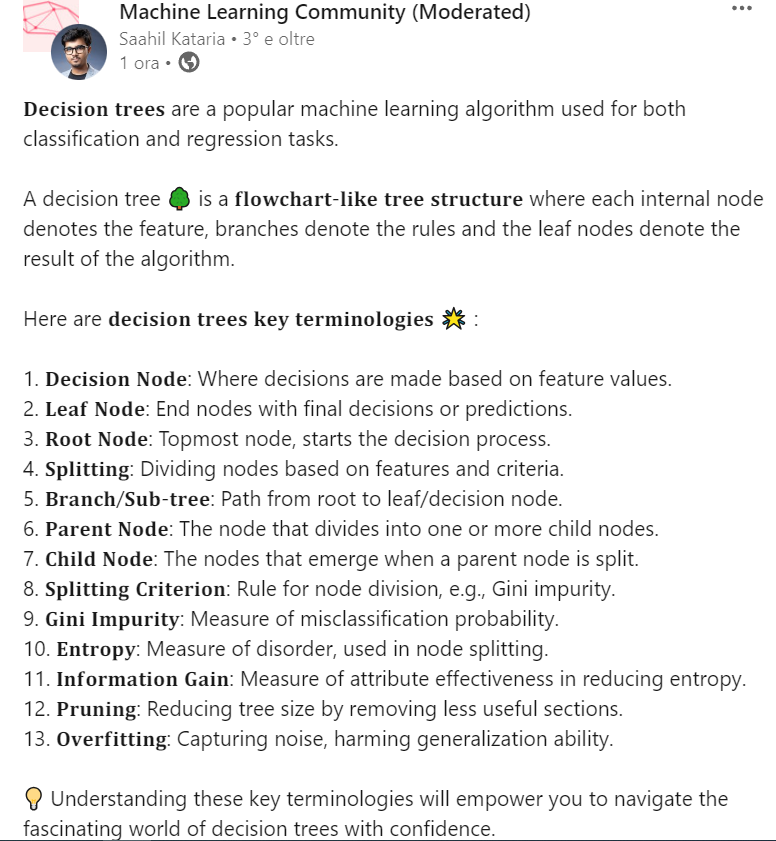

In [18]:
## Un pò di terminologia
Image('decision_tree_post.png') if IN_COLAB else display(Image(filename='decision_tree_post.png'))

... con la relativa animazione [qui](https://www.linkedin.com/feed/update/urn:li:activity:7166029729517527041?utm_source=share&utm_medium=member_desktop).<br>

Vedi anche il pdf *Decision Tree in Python using scikit-learn_ the complete guide with code _ Towards AI.pdf*.

In [7]:
if IN_COLAB:
    display(IFrame("/content/Decision Tree in Python using scikit-learn_ the complete guide with code _ Towards AI.pdf", width=1000, height=600))
else:
    display(IFrame("Decision Tree in Python using scikit-learn_ the complete guide with code _ Towards AI.pdf", width=1000, height=600))

E' importante verificare la versione di scikit-learn installata:

In [12]:
# check della versione di scikit-learn installata
print(sklearn.__version__)

1.7.2


A ottobre 2025 l'ultima versione di scikit-learn è la 1.7, come da [sito](https://scikit-learn.org/stable/).<br>
Alla stessa data Google Colab NON ha ancora fatto l'upgrade ed utilizza la versione 1.6.1.

---
Questo notebook è stato sviluppato con la versione 1.6.1 e, in linea teorica, potrebbe avere problemi con una versione di scikit-learn prececente o successiva.

Con la tecnica degli **ambienti virtuali**  (VE) è possibile creare nel tempo VARI ambienti contenenti un codice Python, una versione Python e la versione deim package COERENTI.

Se non si crea un VE ad hoc per il progetto in corso si usa il VE di default *base*.

L'ambiente corrente in utilizzo è facilmente verificabile da un prompt Anaconda.

Tutte le installazioni, disinstallazioni e upgrade di package che eseguiamo hanno luogo nel VE corrente. Se apriamo il notebook in un altro VE esse non risultano.

---

# Le metriche di impurità

L'albero cerca di costruire delle **regioni omogenee**; si pone dunque il problema di disporre di una **metrica** che appunto misuri quanto un dato dataset (quello iniziale oppure uno intermedio, cioè già frutto di alcuni split, oppure ancora la foglia finale) è omogeneo ("puro") oppure disomogeneo ("impuro").

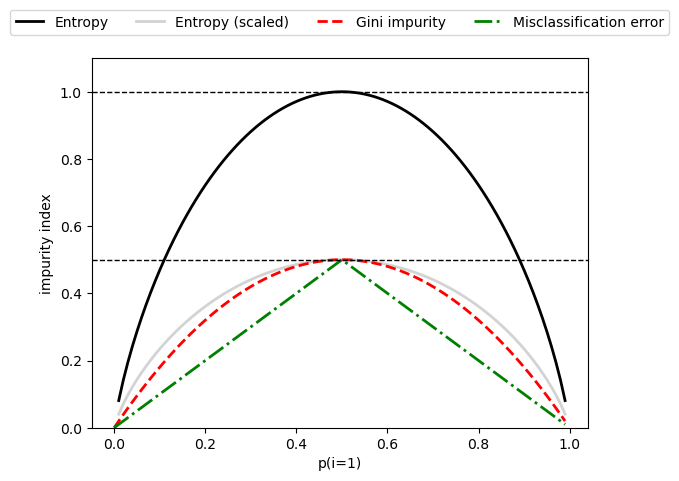

In [13]:
# plot di PML (p.96)
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)',
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')

plt.rcParams["figure.figsize"] = (10,8)

plt.show()
                                        # --> la p sono stimate in base alle frequenze campionarie

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset al valore di default per i plot successivi



Una figura simile con **6 ipotetici nodi intermedi di 10 clienti l'uno**, appartenenti ciascuno alla classe + oppure alla classe - , è rappresentata qui sotto (con le relative p(+) in ascissa e entropia in ordinata:

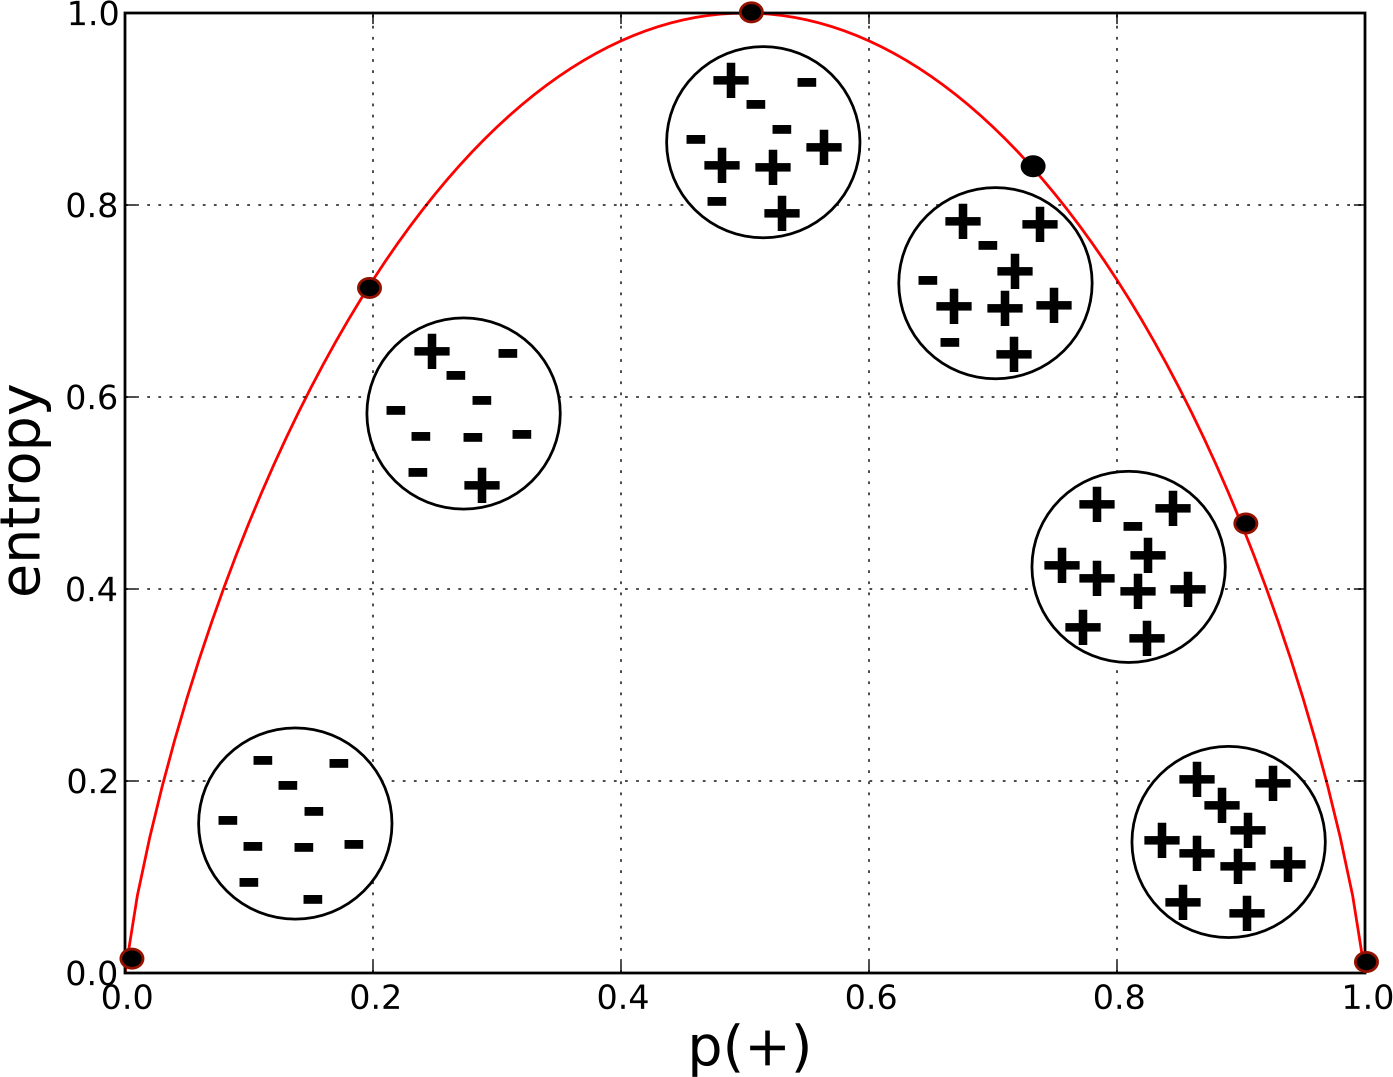

In [14]:
Image('dsfb_0303.png') if IN_COLAB else display(Image(filename='dsfb_0303.png'))

# Personalizzazione del notebook
Questo notebook è costruito per ridurre al minimo il costo/tempo di **personalizzazione sui vostri dati**.<br>
La personalizzzaione sul vostro dataset impatterà su 3 punti in particolare (per questo notebook):
* la `pd.read_csv` del **vostro** dataset; se il nome del dataframe lo volete diverso da *df_credit* fate semplicemente un *trova e sostituisci*
* nell'EDA i metodi di esame colonna saranno ovviamente riferiti alle colonne del *vostro* dataset
* la definizione delle due liste `predictors` e `outcome`, con i nomi delle *vostre* colonne

# Caricamento dei dati
Usiamo il famoso dataset *german_credit_data*, creato ad hoc negli anni '90 da un professore universitario tedesco.

Spesso nel ML si usano dataset **simulati** (creati ad hoc) anzichè dataset **reali**. I dataset simulati:
- hanno il limite che spesso NON sono "sporchi" come i dataset reali, cioè spesso <u>non</u> hanno outlier e valori mancanti (MV)
- tuttavia, essendo costruiti ad hoc, possono **esibire delle proprietà** che magari un dataset reale non esibisce; ad esempio: pattern, trend, correlazioni, distribuzioni di probabilità (di colonna) particolari, ecc. E risultare quindi *più interessanti* per il ricercatore.

I dataset reali, inoltre, spesso **non sono semplicemente disponibili** perchè contengono <u>informazioni super-sensibili</u>, non facili da anomizzare.

In [15]:
# Importing the data
df_credit = pd.read_csv("german_credit_data.csv",index_col=0)
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


🔍 Significato del dataset

Il file *german_credit_data.csv* è un dataset classico di machine learning e data analysis che rappresenta **informazioni su clienti a cui è stato concesso un credito (prestito)**.

L’obiettivo tipico è prevedere se un cliente è un “buon” o “cattivo” pagatore — cioè se restituirà o meno il prestito.

Questo dataset viene spesso utilizzato per:
- esercizi di classificazione binaria (“Good” vs “Bad” credit);
- analisi di rischio creditizio;
- studi di fairness e bias (età, sesso, ecc.);
- modellazione con logistic regression, **alberi decisionali**, o reti neurali.

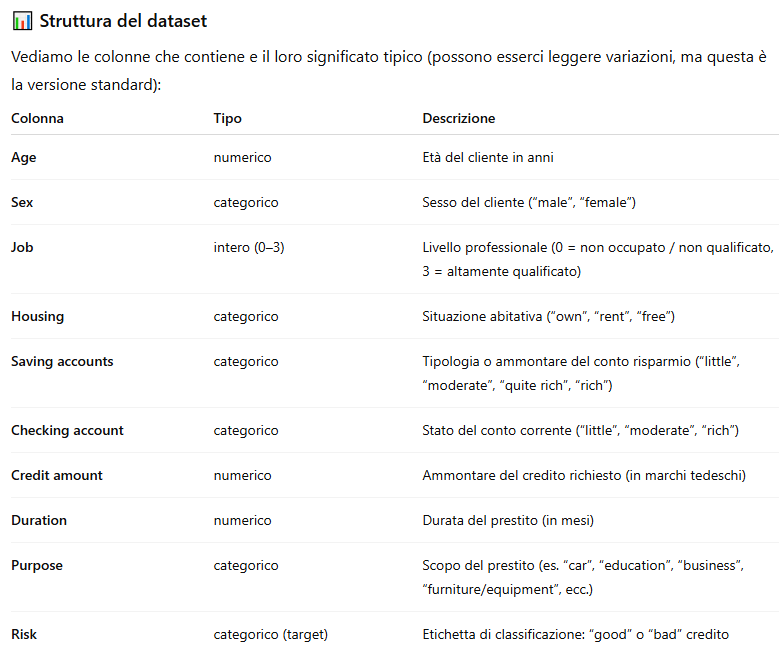

In [20]:
Image('struttura_german_credit.png') if IN_COLAB else display(Image(filename='struttura_german_credit.png'))

Le prime 9 colonne sono i **predittori**, l'ultima colonna è la **risposta**. La determinazione della colonna risposta NON è data dalla posizione della colonna nel dataframe (la prima o l'ultima), ma è una nostra **scelta** applicativa. La scelta della colonna *Risk* è indubbiatamente molto sensata ma non obbligatoria.

*Good* e *bad* sono dati storici, verificati dalla banca **a posteriori**. E' l'**etichettatura** (il *labelling*), spesso il costo principale del modello predittivo.

Dei 9 predittori:
- i primi 7 sono dati socio-demografici del cliente
- gli ultimi 2 (*Duration* e *Purpose*) sono dati del prestito.

Per esattezza, la singola riga rappresenta un prestito, richiesto da un determinato cliente. In teoria, potremmo avere due differenti prestiti (come importo e durata) richiesti dallo STESSO cliente.

Su questo dataset, come detto prima, possiamo fare molte cose:
- **EDA**: analisi esplorativa dei dati (vogliamo **capire** i dati), <u>senza costruzione di modelli predittivi</u>; ad esempio: qualche plot (scatterplot, boxplot, istogrammi, ecc), ricerca outlier, ricerca MV, analisi delle correlazioni, ricerca di trend e pattern nei dati, ecc
- costruire (fittare) un modello di previsione (su una certa colonna risposta) - --> **ML predittivo**
- segmentare il dataset --> **clustering** (ML non supervisionato)

EDA è spesso uno **step preliminare** ai modelli predittivi.

---
Se vogliamo costruire un modello predittivo per una delle sue colonne una scelta naturale, ma come detto non obbligata, è la colonna *Risk*.

> La colonna *Risk* è riferita al futuro (le previsioni future), ma probabilmente sarebbe meglio denominata in questo dataset come **Default** (cioè riferita al passato, che è noto) con 2 possibili valori: 0 (False) e 1 (True). I 2 valori della colonna sono invece *good* e *bad* (riferiti appunto al futuro) da intendersi rispettivamente, in modo secondo me più chiaro, come 0 (no default) e 1 (default).

**Poichè la colonna *Risk* è categorica (in sè, al di là del suo formato, alfanumerico in questo caso), è un problema (predittivo) di classificazione e dunque dobbiamo usare un algoritmo di ML per la classificazione**, in questo notebook gli alberi di decisione (che comunque sono utilizzabili anche per problemi di regressione con risposta numerica).

---

L'immagine qui sotto illustra la **fondamentale differenza tra variabili qualitative e quantitative**:

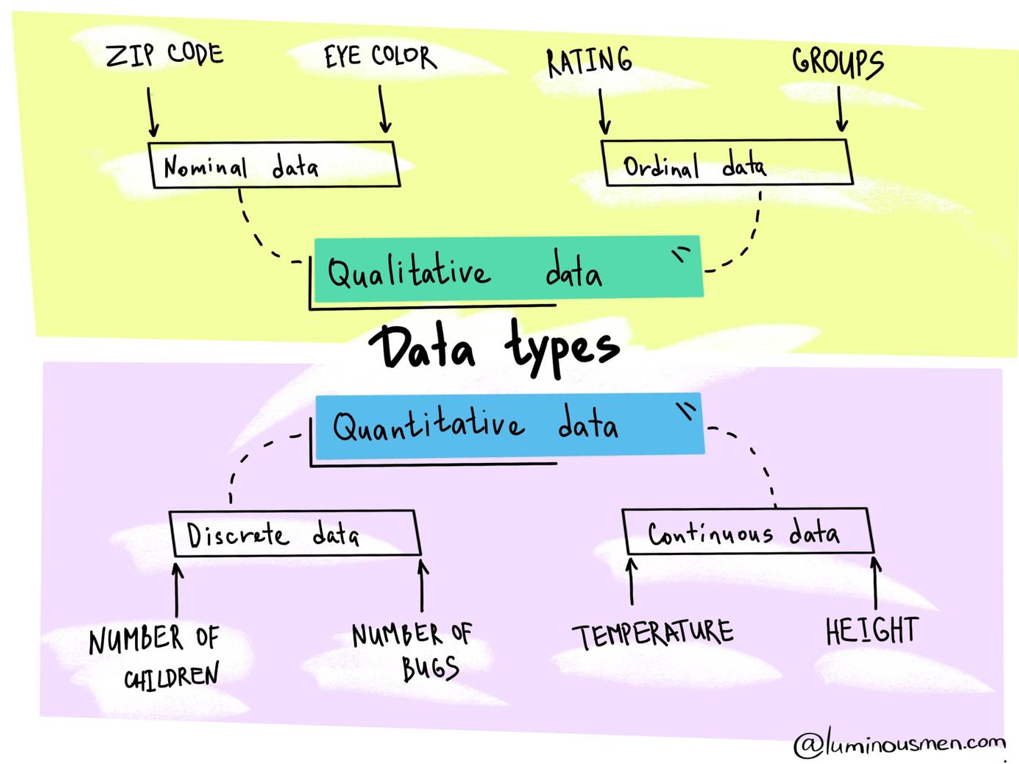

In [22]:
Image('tipi_variabili.png') if IN_COLAB else display(Image(filename='tipi_variabili.png'))

Una buona abitudine è quella di **rimescolare** il dataset, che potrebbe infatti contenere degli ordinamenti per colonne che non ci sono noti e non rileviamo e che potrebbero influenzare i risultati dall'algoritmo. Si fa in questo modo:

In [ ]:
n = df_credit.shape[0]            # il numero di righe del dataset

df_credit = df_credit.sample(n, random_state=1000)
                                  # l'estrazione campionaria di tutte le righe (una volta sola per riga perchè
                                  # l'argomento 'replace' = False - il default) con sovrascrittura del dataset originario
                                  # con il suo campione --> l'effetto è il rimescolamento casuale di tutto il dataset.

                                  # random_state è il seme, che garantisce la RIPRODUCIBILITA' dell'operazione

In [ ]:
df_credit.head()

In [ ]:
df_credit.shape   # le dimensioni NON sono cambiate!

> Il campionamento di default del metodo *sample* è infatti **senza riimmissione** della riga nel dataset (*replace = False*), cioè, una volta che una riga viene selezionata, non può essere selezionata di nuovo nello stesso campionamento.

# EDA
Per iniziare, facciamo un pò di **analisi dati esplorativa (EDA)**.

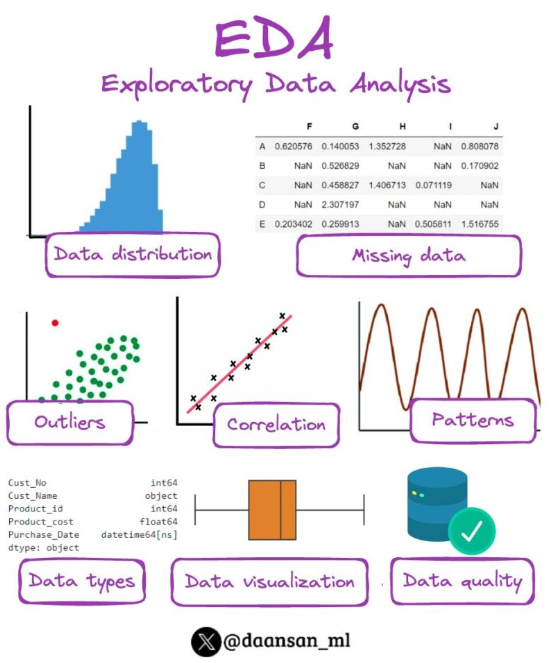

In [23]:
Image('EDA.png') if IN_COLAB else display(Image(filename='EDA.png'))

Cominciamo con la verifica del **numero delle dimensioni del dataframe e del loro *size*** (la cardinalità della dimensione):

In [ ]:
df_credit.shape

Vediamo ora i data type **elementari** (aka, atomici):

In [ ]:
df_credit.dtypes  # i data type elementari

Il formato CSV - quello più utilizzato nel ML, per molte motivi - NON include la definizione del datatype, come invece in una tabella SQL o in un file excel. La funzione pandas *read_csv*, che ha prima caricato i dati nel dataframe *df_credit*, deve pertanto **DEDURRE** il datatype di ogni colonna tramite l'esame di tutti i valori della colonna. Quindi spesso, per mancanza di metadati, deduce il formato scorretto. In questo caso, infatti, le colonne *Sex*, *Housing*, *Saving Account*, *Checking Account*, *Purpose* sono chiaramente categoriche (perchè possono assumere un numero finito e predefinito di valori), il formato *object* (stringa in pandas) non è appropriato per esse e dovrà essere convertito nel più appropriato datatype pandas *Category*.

Un passo fondamentale della EDA è l'individazione di eventuali MV o outlier (valori molto fuori range). Tra l'altro, sia gli MV che gli outlier **impattano molto** sulle previsioni di alcuni algoritmi di ML.<br>
Un modo semplice e veloce per esaminare se nel dataset ci sono MV (e in parte anche outlier) è usare il metodo *sample* con **n=k, con k piccolo, ad esempio 10**, e eseguire il campionamento un buon numero di volte verificando ogni volta, al volo, la presenza di MV (facili da cogliere) e degli outlier (meno facili da cogliere al volo rispetto ai MV):

In [ ]:
n = 10                 # un buon compromesso tra numero di campionamenti e leggibilità veloce dei risultati
df_credit.sample(n)    # ovviamente NOn definiamo il seme

Vediamo i data type **aggregati**:

In [ ]:
type(df_credit)

In [ ]:
type(df_credit['Age'])

Un passo fondamentale della EDA è il calcolo delle **statistiche** delle varie colonne (numeriche):

In [ ]:
round(df_credit.describe(),2)   # per i soli dati numerici

**Quanti sono i livelli** di una variabile categorica? E **quante righe** ci sono per ogni livello? C'è la funzione numpy `np.unique` e soprattutto il metodo pandas `value_counts`:

In [ ]:
# elenco valori unici con funzione numpy (senza conteggi)
np.unique(df_credit['Housing'])        # 3 livelli

In [ ]:
# calcolo valori unici (sempre di 'housing' con metodo pandas
df_credit['Housing'].value_counts()    # le righe per livello

In [ ]:
df_credit['Purpose'].value_counts()    # le righe per livello

In [ ]:
df_credit['Checking account'].value_counts()    # le righe per livello

Occorre infine considerare i livelli (e la loro numerosità) anche della colonna risposta.

In [ ]:
df_credit['Risk'].value_counts()       # le righe per livello

Nei problemi di classificazione, un aspetto importante è il **bilanciamento** della colonna <u>risposta</u> (rispetto ai suoi possibili valori).<br>
Questo dataset è abbastanza bilanciato (perchè lo è stato a monte da parte del prof. tedesco, non perchè lo fosse nella realtà).<br>
Se esso fosse molto sbilanciato, ad esempio 1% bad e 99% good (come può essere nella realtà), l'algoritmo non "imparerebbe" bene a riconoscere i *bad*.<br>
In questi casi, nei quali cioè l'**evento di interesse** è raro, occore <u>ribilanciare il dataset</u>, in vari modi. Uno dei più diffusi ed efficaci è lo [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis), [qui](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) e [qui](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/) in python.

Terminata la EDA (qui molto sintetica), costruiamo il **modello** predittivo del *Risk* in funzione delle altre colonne.<br>
Questa è una cella chiave, dove si valorizzano i due oggetti `predictors` e `outcome`,m e dunque li potrere PERSONALIZZARE in base al VOSTRO dataset

In [ ]:
# dividiamo le variabili in due gruppi  (mere liste di colonne):
predictors = ['Age','Sex','Job','Housing','Saving accounts','Checking account','Credit amount','Duration','Purpose']
outcome = 'Risk'  # a volte chiamato 'risposta' oppure 'target'

# La dummizzazione
Vediamo ora il fondamentale aspetto della **dummizzazione**, rilevante a prescindere dall'algoritmo di ML utilizzato.

(*) Nell'informatica una variabile *dummy* è una variabile binaria numerica.

**Nota generale**<br>
Gli algoritmi di ML lavorano con i numeri (cioè in spazi lineari $\mathbb{R}^{p}$, gli alberi, oppure $\mathbb{R}^{p+1}$, la regressione, dove $p$ è il numero dei predittori), quindi le variabili **predittore** di tipo categorico - formattate sia in modo numerico che alfanumerico (*object*) - devono essere <u>preventivamente</u> tradotte in variabili booleane (per poter applicare l'algoritmo predittivo). Il booleano è infatti un datatype numerico. Ci sono vari modi per farlo, il più diffuso dei quali in *pandas* è la funzione pandas `get_dummies`. Le *dummies* sono variabili binarie, che - al di là della loro rappresentazione (*True*/*False*) - sono intrinsecamente booleane. Tutti i software infatti trattano internamente *True*/*False* come 1/0.

> <u>In generale</u>, a prescindere da *scikit-learn*, gli alberi possono trattare nativamente anche le feature categoriche.<br>
> Le classi `DecisionTreeClassifier` e `DecisionTreeRegressor`di *scikit-learn*, tuttavia, NON gestiscono nativamente le feature categoriche, che devono quindi obbligatoriamente essere preliminarmente convertite in una serie di **variabili binarie dummy**, proprio come si deve fare con altri algoritmi predittivi, in primis la regressione.

Dunque *dummizziamo* il nostro dataset:

In [ ]:
X = pd.get_dummies(df_credit[predictors],drop_first=False)   #  X: tante righe e tante colonne --> è una MATRICE (dataframe)
y = df_credit[outcome]                                       #  y: tanti elementi--> è un vettore (series)

**QUATTRO NOTE** sulla cella precedente:

---
Si dummizzano i predittori, NON la risposta!

---
Due **convenzioni** (in matematica ed anche nel Machine Learning)<br>
* indicare la matrice dei predittori come X e la riposta come Y perchè l'algoritmo di ML implementa un modello del tipo $Y=f(X)$<br>
* usare le maiuscole per indicare MATRICI e le minuscole per indicare VETTORI

---

Come fa la funzione 'get_dummies' a **riconoscere le variabili categoriche** da esplodere in una serie di variabili dummy?

Ecco la risposta di Gemini:<br>
*La funzione *pd.get_dummies* riconosce le variabili categoriche **basandosi sul loro datatype**. Per default, *get_dummies* convertein variabili dummy le colonne che hanno un datatype **object** (che in pandas rappresenta tipicamente le stringhe) o **category**.*

*Nelle celle precedenti, abbiamo visto che colonne come 'Sex', 'Housing', 'Saving accounts', 'Checking account' e 'Purpose' erano state caricate con datatype **object**. È per questo che *get_dummies* le ha automaticamente identificate come categoriche e le ha "esplose" in variabili dummy. Le colonne con datatype numerico (int64, float64, ecc.) non vengono modificate di default da *get_dummies*.*


---
L'argomento *drop_first=False* della funzione *pd.get_dummies* **forza la codifica one-hot**.<br>
Vedi [qui](https://it.wikipedia.org/wiki/One-hot).

Vediamo i risultati della dummizzzione:

In [ ]:
X.head()

Bene, ma c'è un problema. La codifica one-hot  è ottima in generale, ma nei modelli di ML può portare al problema della [**multi-collinearità**](https://en.wikipedia.org/wiki/Multicollinearity) a causa della **ridondanza** della informazione. Per evitarlo si deve eliminare una delle variabili dummy, ovvero, se i livelli della variabile categorica sono $k$ occorre creare solo $k-1$ dummy variable. Lo si fa impostando l'argomento *drop_first* a *True* della funzione *pd-get_dummies*:

In [ ]:
X = pd.get_dummies(df_credit[predictors],drop_first=True)   
y = df_credit[outcome]                                       

In [ ]:
X.head()

Ogni variabile categorica con $k$ livelli è ora rappresentata da $k-1$ dummy variable, una codifica più compatta e non ridondante (più adatta al ML predittivo).

> Sia la standardizzazione dei predittori QUANTITATIVI (eventuale, non necessaria con gli alberi) che la dummizzazione delle variabili categoriche si applica **solo ai predittori**, non alla risposta (la cui unica possibile trasformazione è nel data type di pandas *category*).

# Le variabili categoriche (vs quelle numeriche)

In [ ]:
if IN_COLAB:
  from google.colab import files
  uploaded = files.upload()  # si aprirà un prompt per caricare il PDF

## Note sulla codifica delle variabili categoriche (saltabile)

If you use **one-hot encoding**, read this:

(It might introduce a problem in the dataset)

When we one-hot encode categorical data, we unknowingly introduce **perfect multicollinearity**.

Multicollinearity arises when two or more features can predict another feature.

As the sum of one-hot encoded features is **always 1**, it leads to perfect multicollinearity and it can be problematic for models that don't perform well under such conditions.

This is often called the **Dummy Variable Trap**.

Talking specifically about linear regression, for instance, it is bad because:
- In some way, your data has a redundant feature
- Regression coefficients aren't reliable in the presence of multicollinearity, etc.

So how to resolve this?

The **solution is simple**.

**Drop any arbitrary feature** from the one-hot encoded features.

This instantly mitigates multicollinearity and breaks the linear relationship that existed before.


In [ ]:
Image('encoding_right.png') if IN_COLAB else display(Image(filename='encoding_right.png'))

In [ ]:
display(type(X))
display(type(y))     # --> un df anche se c'è una sola colonna

Secondo il classico approccio della Regressione, per ogni variabile categorica con *k* livelli abbiamo creato *k-1* dummy variable.

**Attenzione**:<br>
*In contrast to the situation with statistical models such as regression, **all k binaries** should be created and used with CART. While mathematically this is redundant, since k − 1 dummies contain the same information as k dummies, this redundant information does not create the multicollinearity problems that it does for linear models. Moreover, in CART the use of k − 1 dummies can yield different classifications than the use of k dummies, and lead to an imbalance in the contribution of the different categories to the model.*<br>
Shmueli, Galit; Bruce, Peter C.; Gedeck, Peter; Patel, Nitin R.. Data Mining for Business Analytics (p.193 and 223). Wiley.

In [ ]:
X_full = pd.get_dummies(df_credit[predictors])  # un one-hot encoding puro
X_full

La dummizzazione ha portato all'aumento delle colonne predittore, da 9 a 24, ora tutte numeriche (True = 1, False = 0).

In [ ]:
X_full.shape

*Bottom-line*: possiamo usare **sia il dataframe *X* che *X_full***.

# Split dati

Una delle regole fondamentali del ML è che un algoritmo deve essere allenato (fittato=adattato) su dati di training e valutato su ALTRI dati (non di training) detti di test o di validazione.

Possiamo procedere secondo lo schema solito, usato anche - ad esempio - per gli algoritmi KNN e Regressione Lineare.

In [ ]:
# ora lo split in training e test, tramite questa funzione MULTI-OUTPUT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=100, stratify= y)
                                                        # 'random state' (un numero QUALSIASI) è il seme che garantisce la RIPRODUCIBILITA'
                                                        # 'stratify=y' --> "data is split in a stratified fashion, using this as
                                                        #  the class labels.

In [ ]:
X_train.head()

In [ ]:
Image('data_partitioning.png') if IN_COLAB else display(Image(filename='data_partitioning.png'))

> La percentuale di test tipicamente oscilla da un 20% ad un 50% massimo, con 25-30% valori più tipici.<br>
> Comunque si scelga questa percentuale, rimane il trade-off intrinseco: cioè vorremmo avere il maggior numero possibile di righe di training ed anche il maggior numero possibile di righe di test. La coperta è corta; questo problema è risolvibile  solo con la tecnica della **Cross-Validazione**.

Per il **campionamento stratificato** vedi [questa voce Wikipedia](https://it.wikipedia.org/wiki/Campionamento_stratificato) e [questo post stackoverflow](https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn).

Prima di procedere verifichiamo che la funzionne *train_test_split* abbia fatto il suo dovere:

In [ ]:
# il data type degli output della funzione:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

In [ ]:
# le dimensioni degli output della funzione:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

**Breve recap**:<br>
Cioè, abbiamo suddiviso e rinominato il nostro dataset iniziale `df_credit` (1000 righe, 20 colonne):
- per colonna: tra i 19 *predictors* e la colonna *outcome*
- abbiamo dummizzato le colonne predittore
- abbiamo rinominato predittori e outcome in X e y
- abbiamo diviso per riga: tra il dataset di test (25% delle righe di X e degli elementi di y - il resto rimane in training

Ovviamente la funzione *train_test_split* ha campionato X ed y in modo **consistente**.

In [ ]:
display(X_test.head())
display(y_test.head())

La funzione `train_test_split` ha rispettato anche le proporzioni di `good` e `bad`.

In [ ]:
y_train.value_counts()  # la proporzione è rispettata, perchè: 225/750 = 300/1000 = 0.3

In [ ]:
y_test.value_counts()  # la proporzione è rispettata, perchè: 75/250 = 0.3

La standardizzazione dei predittori quantitativi NON è necessaria con gli alberi, anche se può essere utile per la visualizzazione comparata, ad es. i boxplot delle varie colonne a confronto (PML, p. 96),

# Il fit

**Le relazioni tra dati, algoritmo e modello**.<br>
> Applicando (*fit* = letter. "adattamento") <u>l'algoritmo</u> scelto, ad esempio l'albero decisionale, ai <u>dati</u> scelti (ad es. *german_credit_data*) si ottiene un <u>modello</u> (in questo caso un determinato albero). Quindi il modello è l'output del fit. Il modello può essere una equazione matematica (più o meno complessa), una rete neurale a vari livelli, un albero (cioè un oggetto del tipo di quello mostrato

Gli alberi possono costruire **Decision Boundary complessi** dividendo lo spazio dei predittori/feature in regioni rettangolari, cioè **parallelepipedi**.<br>
Occorre comunque fare attenzione, poichè, più *profondo* è l'albero (cioè, maggiore è il suo numero di livelli), più complessi sono i DB risultanti e maggiore è il rischio di overfitting.<br>
Useremo in questo esempio una profondità massima dell'albero di 4 (livelli) e l'indice di Gini come misura dell'impurità.

**Piccola nota preliminare di OOP ([Object-Oriented Programming](https://it.wikipedia.org/wiki/Programmazione_orientata_agli_oggetti))**<br>
* Nella OOP il primo metodo "invocato" (cioè "chiamato", "eseguito") è il metodo "**costruttore**", che cioè "crea" una **istanza** ("un oggetto", appunto) di una certa **classe**
* Una classe tipica è il `DataFrame`; quando creiamo un dataframe per elencazione delle sue colonne e dei suoi valori oppure tramite caricamento da file esterno, in realtà istanziamo un nuovo oggetto della classe `DataFrame`
* la classe alla quale un oggetto appartiene è verificabile con la funzione `type`
* un oggetto di una certa classe **eredita** tutti i metodi disponibili per quella classe; ad esempio, un oggetto `DataFrame` eredita i vari metodi visti nella sezione *pandas* del notebook *A. Introduzione*, alcuni dei quali abbiamo visto anche nella precedente EDA (ad esempio, `head`, `shape`, `describe`, ecc)
* quindi, il primo passo nel ML con *scikit-learn*, una volta scelto l'algoritmo (cioè la classe *estimator*) da applicare ai nostri dati (di training), è costituito dall'invocazione del metodo costruttore; l'oggetto creato da questo metodo è un'istanza di algoritmo
* la **configurazione dei parametri** dell'algoritmo (*estimator*) è fatta nell'invocazione del metodo costruttore, i dati sono invece passati in input al metodo di fit

Il PRIMO PASSO per usare un algoritmo di scikit-learn (in scikit-learn si chiamano *estimators*) è la sua **istanziazione**. Durante l'istanziazione possono essere definiti i parametri di input (non più modificabili nel prosieguo).<br>
Siamo abitutati in genere a istanziare oggetti di memoria (ad esempio una lista od un dataframe). In scikit-learn si istanziano anche gli algoritmi.<br>

---
> Attenzione al **flusso**: nel ML si applica un **algoritmo** (che a volte è anche detto **metodo** - da non confondere con i 'metodi' delle classi) ai **dati di allineamento** (questa applicazione in gergo è detta **fit** - letter. "adattamento") e otteniamo un **modello** di ML allenato, da testare. Ad esempio, si parla di algoritmo di regressione e di modello di regressione (l'output). Allo stesso modo, c'è l'algoritmo dei CART e poi il modello dell'albero (l'output).

---

In [ ]:
tree_model = DecisionTreeClassifier(criterion='gini',  # da alcune prove sembra che in questo caso 'entropy' dia
                                                       # un maggior numero di mis-classificazioni
                                    max_depth=4,       # solo 4 per evitare overfitting
                                    random_state=1)    # nella logica degli split binari in alcuni casi c'è un aspetto
                                                       # casuale
type(tree_model)

L'oggetto `tree_model` è una **istanza** della classe degli algoritmi `DecisionTreeClassifier`, i cui parametri sono specificati all'interno delle ().<br>
La ragione per la presenza del parametro `random_state` nella configurazione è spiegata [qui](https://chatgpt.com/share/67223a15-c97c-8012-8e7f-70cdf572c2c7).

In [ ]:
tree_model

Gli argomenti di input di un algoritmo di scikit-learn sono detti **parametri** (*parameters*); quelli di output (del fit!! - l'istanziazione NON restituisce nulla) sono detti **attributi** (*attributes*). I nomi degli attributi terminano sempre con il carettere *_*.

In [ ]:
help(DecisionTreeClassifier)  # la stessa finestra ottenibile premendo maiusc+tab dentro le parentesi tonde dello stimatore

All'oggetto `tree_model` della classe  `DecisionTreeClassifier` (istanziato prima) possiamo applicare TUTTI i metodi disponibili per la classe medesima. In particolare, per iniziare, il metodo `fit`.<br>
La lista di questi metodi è disponibile nella [documentazione on-line di scikit-learn](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html) oppure da codice con *.tab* sull'istanza create dell'algoritmo.
NB. La sintassi di chiamata dei metodi di una classe in python è sempre del tipo: oggetto.metodo(argomenti-input).

In [ ]:
tree_model.fit(X_train, y_train)   # solo a questo livello (metodo di fit) forniamo all'algoritmo i DATI

> L'esecuzione del fit significa che è stato prodotto il modello di output (in questo caso l'albero). Il metodo `fit` non visualizza nulla, in realtà il suo output è il modello (l'albero) - l'attributo `tree_`), che è contenuto all'interno dell'oggetto.<br>
> Infatti, nella programmazione ad oggetti (OOP), i vari metodi modificano lo stato interno dell'oggetto. Richiamando gli opportuni attributi, possiamo estrarre le informazioni dall'oggetto.

Come si evince dalla [documentazione online](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) di `DecisionTreeClassifier`, **dopo** avere invocato il metodo di `fit`, al quale abbiamo passato i dati (al metodo costruttore invece NON li avevamo ancora passati!) possiamo visualizzare gli attributi (aka, proprietà) dell'oggetto (tutti terminanti con `_`), alcuni dei quali **già noti**:

In [ ]:
tree_model.n_classes_.item()              # il numero di classi della risposta (lo conoscevamo già)

In [ ]:
tree_model.feature_names_in_       # l'elenco delle feature - cioè dei predittori - dummizzate (lo conoscevamo già)

In [ ]:
tree_model.classes_                # informazione MOLTO UTILE più avanti (quando vedremo le probabilità delle previsioni)
                                   # perchè dice quale è la PRIMA classe (in questo caso 'bad')

Sino a qui abbiamo estratto informazioni che già conoscevamo perchè oggetto della analisi esplorativa preliminare. Da qui in poi estraiamo info nuove e più utili:

In [ ]:
tree_model.n_features_in_          # Number of features SEEN (esaminate, valutate) during fit.

Ed ora **l'importanza delle feature** nel fit (cioè nel determinare la risposta), tramite l'attributo `feature_importances_`:

In [ ]:
tree_model.feature_importances_

Le vogliamo visualizzate in pandas, etichettate ed ordinate:

In [ ]:
pd.DataFrame(tree_model.feature_importances_,columns=tree_model.feature_names_in_)  # --> ERRORE istruttivo!!

L'errore è spiegato [qui](https://chatgpt.com/share/67292109-4940-8012-ac90-2b7f8aa48b0d).

In [ ]:
feature_imp_df = pd.DataFrame(tree_model.feature_importances_.reshape(-1, 1), columns=["Importance"], index=tree_model.feature_names_in_)
feature_imp_df.sort_values(by = 'Importance',ascending = False,inplace=False)

# La visualizzazione dell'albero
Attenzione: la funzione `plotDecisionTree` utilizza lo strumento **graphviz** che deve essere installato sul PC.

In [ ]:
tree_model.tree_                   # --> non visualizza l'albero, dice solo il tipo di oggetto.
                                   #     per visualizzare l'albero occorrono delle funzioni ad hoc

Con la funzione `plotDecisionTree` (NON è un metodo!) possiamo **estrarre** dalla memoria dell'oggetto l'albero (ilmodello) creato (fittato) dall'algoritmo.

In [ ]:
plotDecisionTree(tree_model,feature_names=X_train.columns,max_depth=10)   # funzione del package 'dmba'

I nodi sono rappresentati in **due nuance di colori**: <u>azzurra</u> quando i good sono più dei bad, <u>rosa</u> quando i bad sono più dei good. L'intensità del colore indica la purezza del nodo (cioè quanto una classe prevale sull'altra). Quindi, nodi abbastanza bilanciati tendono al colore bianco, nodi sbilanciati tendono ad un colore più intenso.

La logica di funzionamento dell'algoritmo degli alberi è ben spiegata [qui](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). Limitiamoci qui a dire che l'algoritmo degli alberi è **iterativo**, prova tutti i predittori con tutti i possibili valori di cutoff e cerca di produrre delle regioni le più omogenee possibili.

NB. Tutte le visualizzazioni di albero disponibili in scikit-learn, a mia conoscenza, visualizzano come prima riga del nodo lo
split ad esso DOPO applicato. Ciò può risultare **fuorviante**. <br>
Ogni box, a partire dal primo, che si riferisce alla radice e contiene tutti i dati del dataset (di training), descrive il nodo in termini di numero di osservazioni (o percentuali), misura di impurità, valori di classe ed eventualmente (se richiesta) la previsione.<br> A valle di ciò, o meglio in base a ciò, il metodo sceglie di applicare uno split/valore, che è visualizzato però nella prima riga, anzichè, come forse risulterebbe più chiaro, nell'ultima riga del box.

Risposta su stackoverflow alla mia domanda su questa rappresentazione degli alberi:<br>

*The scikit-learn design emphasizes a “forward-looking” view, focusing on the decision process.*<br>
*This means that the focus is on which feature is being split on and at what threshold.*
*This design likely aligns with the idea that once a node is created, the split criterion immediately defines the future structure of the tree.*
*No way to change this behavior in sklearn.*

Per la visualizzazione degli alberi prodotti da scikit-learn vedi [questo articolo](https://mljar.com/blog/visualize-decision-tree/).

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
feature_names = tree_model.feature_names_in_
class_names = tree_model.classes_
plot_tree(tree_model, feature_names=feature_names, class_names=class_names, filled=True)

plt.show()

L'albero non è leggibile; vedi [questa chat](https://chatgpt.com/c/672245e3-6160-8012-a75c-8ab63a7bde56) per alcuni consigli.

In [ ]:
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20, 15))
_ = plot_tree(tree_model,
              feature_names=X_train.columns,
              class_names=['bad', 'good'],
              max_depth=3,        # Further limits depth for clarity
              filled=True,        # Colors the nodes based on class
              fontsize=12)        # Increases font size
plt.show()



from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
feature_names = tree_model.feature_names_in_
class_names = tree_model.classes_
plot_tree(tree_model, feature_names=feature_names, class_names=class_names, filled=True)

plt.show()

Vediamo ora la visualizzazione **testuale** dell'albero come sequenza di **if-then-else** annidate. La classe estimator `tree` (sempre di *scikit-learn*) rende disponibile anche un metodo di questo tipo.

In [ ]:
text_representation = tree.export_text(decision_tree=tree_model, feature_names=tree_model.feature_names_in_.tolist()) # vedi post so 72178276
print(text_representation)

## Visualizzazioni specifiche
Molto spesso ci interessa sapere:
* data una riga, a quale foglia appartiene? (con il metodo `apply`)
* data una certa foglia, quante sono le sue righe?
* data una certa foglia, quali sono le sue righe

Rispetto ai dati ORIGINALI (non dummizzati o standardizzati).

La risposta alla prima domanda:

In [ ]:
leaf_indexes = tree_model.apply(X_train)                # l'elenco delle foglie alle quali ogni riga di training è staga assegnata
print(leaf_indexes)

print("\n", pd.Series(leaf_indexes).value_counts())     # la tabella con la cardinalità delle varie foglie

tree_model.apply(X_train[10:15])                        # come prima, ma solo per alcune righe (non tutte)

La risposta alla seconda domanda è questa:

In [ ]:
leaf_indexes = tree_model.apply(X_train)
target_leaf_index  = leaf_indexes[0]   # la scelta di una foglia (qui, per semplicità, quella della prima riga di training)
rows_in_leaf = [i for i in range(len(leaf_indexes)) if leaf_indexes[i] == target_leaf_index]
              # le [] creano una lista
              # la riga "i" cicla da 0 a 749 (cioè esamina tutto il dataframe di training 'X_train')
              # per ogni riga: se la sua foglia è quella della prima riga (doppio uguale) --> si estrae quel numero di riga

rows_in_leaf  # tutte le righe che appartengono alla foglia alla quale appartiene la prima riga

Ok, ora estraiamo le righe del dataframe originario di training (`X_train`) che appartengono ad una certa foglia target (ad es. quella sopra scelta):

In [ ]:
is_in_target_leaf = (leaf_indexes == target_leaf_index)  # vettore booleano di 750 elementi (appartiene oppure no)
X_train[is_in_target_leaf]                               # subsetting booleano

E' infine possibile estrarre le righe (appartenenti ad una certa foglia) dal dataframe originario (`df_credit`), non direttamente perchè le colonne sono differenti, ma attraverso un passo preliminare: la costruzione del vettore booleano `leaf_indexes` sul dataframe `X`, che è dummizzato.

In [ ]:
leaf_indexes = tree_model.apply(df_credit)  # --> dà ovviamente errore

In [ ]:
leaf_indexes = tree_model.apply(X)

In [ ]:
len(leaf_indexes)   # ora ha 1000 elementi

In [ ]:
is_in_target_leaf = (leaf_indexes == target_leaf_index)  # vettore booleano di 1000 elementi (appartiene oppure no)
df_credit[is_in_target_leaf]

# Salvataggio del modello

In [ ]:
import joblib

joblib.dump(tree_model, 'decision_tree_model.joblib')   # metodo dump: scrive il modello su disco
                                                        # in google colab ci mette qualche secondo

In [ ]:
del(tree_model)

In [ ]:
tree_model    # --> ovviamente dà erore

In [ ]:
# La restore
tree_model = joblib.load('decision_tree_model.joblib')   # carica il modello da disco


In [ ]:
tree_model

**Come si usa un albero?** Facendo **attraversare** (*go thru*) l'albero alla riga e vedendo in quale foglia terminale la riga finisce. Le si assegna una classe od un'altra in base alle frequenze relative della foglia.

# La previsione sui dati di test

Ora, per fare le previsioni, usiamo il metodo `predict` fornito dalla classe *DecisionTreeClassifier*:

In [ ]:
y_test                                    # le vere y
y_pred_test = tree_model.predict(X_test)       # le y previste
classificationSummary(y_test,y_pred_test)      # una funzione del package 'dmba'

In [ ]:
(16+152)/250

Classico errore (in buona fede?) di molte aziende: calcolare la matrice di confusione sui dati di training. In genere i risultati sono migliori.

In [ ]:
y_train                                    # le vere y (di train)
y_pred_train = tree_model.predict(X_train)       # le y previste
classificationSummary(y_train,y_pred_train)      # una funzione del package 'dmba'

# Show number of samples per node in decision tree thanks to *supertree*

# Il plot dei Decision Boundary
Da [questo post](https://stackabuse.com/bytes/plot-decision-boundaries-using-python-and-scikit-learn/).<br>

Requisiti:
- installare **graphviz**
- aggiungere la directory che contiene l'eseguibile `dot` al PATH di Windows, solitamente qualcosa come *C:\Program Files\Graphviz\bin*
- verificare la corretta installazione da anaconda prompt con: *dot -V*

Graphviz è un software open-source che viene utilizzato da Matplotlib per alcune funzionalità avanzate, come la creazione di grafici e diagrammi complessi a partire da descrizioni in un linguaggio di markdown. Matplotlib può utilizzare Graphviz per generare alcune visualizzazioni, come ad esempio la rappresentazione di grafi.

**Come detto, un albero divide lo spazio dei predittori in tante regioni, una per ogni foglia.**<br>
Dopo aver fatto il fit, possiamo visualizzare i [Decision Boundary](https://en.wikipedia.org/wiki/Decision_boundary) prodotti (fittati), ad esempio rispetto ai due predittori `Duration` e `Credit amount`.<br>
Utilizziamo la classe generale di scikit-learn `DecisionBoundaryDisplay` con il metodo `from_estimator` - vedi [qui](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html).

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

# subset delle due colonne di plot
X_train_red = X_train[['Duration','Credit amount']]  #il dataset (di training) ridotto

# costruttore e fit dell'albero sul dataset ridotto --> salviamo in un oggetto di tipo 'DecisionTreeClassifier'
classifier = DecisionTreeClassifier(max_depth=4,
                                    random_state=10).fit(X_train_red,y_train)

# invocazione del metodo 'from_estimator'
disp = DecisionBoundaryDisplay.from_estimator(classifier,                    # il classificatore da usare
                                              X_train_red,                   # i dati
                                              response_method="predict",     # oppure 'predict_proba' come risposta
                                              xlabel=X_train_red.columns[0], # il nome dell'asse X
                                              ylabel=X_train_red.columns[1], # il nome dell'asse Y
                                              cmap=plt.cm.coolwarm,          # lo schema di colore
                                              alpha = 0.5                    # ??
                                             )

# dummizzazione della risposta 'y_train' per usarla come codice colore:
y_train_dv = list(y_train.apply(lambda x: 1 if x in ['good'] else 0))   # nel df la prima classe è 'bad'

# plot del dataset e dei decision boundary
disp.ax_.scatter(X_train_red['Duration'], X_train_red['Credit amount'],
                 c=y_train_dv,
                 cmap=plt.cm.coolwarm)

plt.title(f"Decision Boundary per l'albero fittato su {X_train_red.columns[0]} and {X_train_red.columns[1]}")
plt.show()

e l'albero corrispondente, cioè usando solo le 2 colonne scelte :

In [ ]:
plotDecisionTree(classifier,feature_names=X_train_red.columns)

# L'accuratezza
Calcolata come percentuale delle previsioni corrette rispetto alle previsioni totale (sul dataset di test).<br>
`y_test` sono le etichette vere.<br>
`y_pred` sono le etichette previste.

In [ ]:
accuracy_score(y_test,y_pred_test)   # funzione di scikit-learn

> In genere l'albero spiega bene, ma **non prevede bene**. Per migliorare la capacità predittiva di un albero occorre **potarlo** ed usare la **Cross-Validazione** per trovare i parametri migliori.

E' ovviamente possibile calcolare l'accuratezza di training ancorchè sia poco significativa perchè il modello è stato allenato proprio su queste righe e dunque è in genere molto bravo a classificarle.

In [ ]:
y_pred_tr = tree_model.predict(X_train)
accuracy_score(y_train,y_pred_tr)

E se cambiamo il numero di livelli dell'albero, ad esempio molti, cosa succede?

In [ ]:
tree_model_2 = DecisionTreeClassifier(criterion='gini',  # da alcune prove sembra che in questo caso entropy dia
                                                         # un maggior numero di mis-classificazioni
                                    max_depth=30,        # solo 4 per evitare overfitting
                                    random_state=1)
tree_model_2.fit(X_train,y_train)
display(accuracy_score(y_train,tree_model_2.predict(X_train)))  # le previsioni sul training --> overfitting!
display(accuracy_score(y_test, tree_model_2.predict(X_test)))   # le previsioni sul test

E' il classico overfitting: l'acccuratezza sul training set è aumentata (addirittura 1!) ma l'accuratezza sul test set (qualla che conta) è diminuita.

In [ ]:
plotDecisionTree(tree_model_2,feature_names=X_train.columns) # --> 13 livelli: tutte le foglie sono blu intenso
                                                             #     oppure rosa intenso (cioè foglie pure)

> Un'accuratezza di training molto alta (vicina a 1) ed un'accuratezza di test molto più bassa costituiscono un chiaro segno di [overfitting](https://it.wikipedia.org/wiki/Overfitting). Se, al contrario, sia l'accuratezza di training che di test sono alte, bene, significa che il modello prevede bene. Perchè prevede bene? Per varie ragioni:
> *  dataframe ha un numero di righe sufficiente afffinchè l'algoritmo impari bene
> *  questo algoritmo stima bene il confine decisionale migliore (non noto)
> * i predittori sono quelli giusti, effettivamente utili a prevedere la risposta
> * il fenomeno ha poca casualità

# Le probabilità delle classi
Torniamo all'albero fittato su 4 livelli.

In [ ]:
tree_model.predict(X_test)

In [ ]:
tree_model.predict_proba(X_test)    # la prima probabilità è relativa alla classe ' bad', la seconda alla classe 'good'

In [ ]:
bad_test = tree_model.predict_proba(X_test)[:,0]  > 0.1   # la prima probabilità è relativa alla classe ' bad', la seconda alla classe 'good'
bad_test

Avendo il vettore booleano dei clienti di test con Pr['bad'] > 0.1, possiamo ora fare il subsetting di riga (del test):

In [ ]:
X_test[bad_test]

In [ ]:
tree_model.classes_   # l'ordine delle classi è importante per capire l'output di 'predict_proba'

Le probabilità servono a **due cose, molto utili**:
* se si utilizza il metodo `predict` il cutoff è deciso dal metodo `predict` (è 0.5 se le classi sono 2, il che coincide con la scelta della probabilità più alta); ma in molti scenari di business, costo-FN >> costo-FP. Come ci si cautela? Occorre ridurre il numero di FN anche a costo di aumentare il numero di FP. E' possile gestire questo aspetto abbassando il cutoff. Appena c'è qualche segno dell'evento "negativo" (ad es. il default, la frode, la malattia), anche molto inferiore a 0.5, si classifica come "negativo". Ad esempio, se costo-FN = 10xcosto-FP, si potrebbe mettere il cutoff a 0.1. Cioè sopra Prob(bad) > 0.1 --> si classifica come bad.
* le probabilità possono essere ordinate (le etichette no!). Ciò è molto utile per priorizzare la gestione dei problemi, ad esempio focalizzare le verifiche manuali delle transazioni di carta fraudolente sulle transazioni con Prob(frode) più alta, indipendetemente dal cutoff.

Vediamo un esempio del primo utilizzo ed uno del secondo:

In [ ]:
tree_model.predict_proba(X_test).shape   # il nuovo cutoff; quando Pr[bad] > 0.1 --> classifico bad (per prudenza)

In [ ]:
pd.DataFrame(tree_model.predict_proba(X_test),columns=['prob-bad','prob-good']).sort_values(by='prob-bad',ascending=False)

# La matrice di confusione
Vedi [questa voce di Wikipedia](https://it.wikipedia.org/wiki/Matrice_di_confusione).

In [ ]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

In [ ]:
accuracy_score(y_test,y_pred_test)

Sappiamo da sopra che la prima classe è 'bad', la seconda è 'good'. Quindi: #TP= 27, #TN = 148, #FN = 48,#FP= 27.<br>
La matrice di confusione riporta sulla diagnolale principale le previsioni corrette (per le varie classi), in questo caso: (2+168)/250 = 0.68. Rispetto al calcolo della semplice accuratezza - come fatto prima dalla funzione `acuracy_score` - la matrice di confusione fornisce anche lo spaccato degli errori di classificazione per tipologia, ad es. falso positivo oppure falso negativo.

# Evitare l'overfit

In [ ]:
Image('tree_overfit.png') if IN_COLAB else display(Image(filename='tree_overfit.png'))

La tecnica più semplice per evitare l'overfitting è quella di agire sui tre parametri, in  questo modo:
- limitando `max-depth`
- evitando valori troppo bassi di `min_samples_leaf` e `min_samples_split`.

# Cross-validazione
E' il rimedio principale alla mancanza di dati.

Quando abbiamo usato la funzione `train_test_split` abbiamo scelto l'argomento `test_size=0.25`. Il resto è training. Comunque sia scelto questo valore, le osservazioni di training non possono essere usate per il test, e viceversa (perchè è corretto che sia così). Tuttavia ciò comporta uno "spreco" di righe, grave se i dati sono pochi ed i costi/tempi di acquisizione e pulizia di nuovi dati sono alti. Infatti, in un mondo ideale, vorremmo avere tutte le righe disponibili per il training (perchè in questo modo l'algoritmo "impara" meglio) ed anche tutte le righe disponibili per il test (perchè in questo modo saremmo più confidenti sull'affidabilità dell'accuratezza di test). C'è un inevitabile trade-off.<br>
Vediamo la logica della Cross-Validazione:

In [ ]:
Image('CV_non_innestata.png') if IN_COLAB else display(Image(filename='CV_non_innestata.png'))

La cross-validazione si implementa in scikit-learn in molti modi, uno dei più frequenti è `kfold` - vedi [qui](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [ ]:
kfold = KFold(n_splits=5)    # il metodo costruttore della istanza della classe CV, specificando gli argomenti (NON sappiamo
                             # ancora qual è il dataset, e quindi la suddivisione NON è ancora stata fatta)
                             # 'n_splits' è il numero di partizioni nel quale suddividere il dataset INTERO (è K della slide)

# la CV - non mettere random_state=seed, qui dà problemi (post stackoverflow)
cv_results = cross_val_score(DecisionTreeClassifier(

                                                           # i "parametri" del DecisionTreeClassifier (del metodo costruttore per istanziare)
                                    criterion='gini',      # da alcune prove sembra che in questo caso entropy dia
                                                           # un maggior numero di mis-classificazioni
                                    max_depth=4,           # solo 4 per evitare overfitting
                                    random_state=1),       # l'algoritmo da usare per il fit (nuovo!)

                                                           # gli "parametri" di'cross_val_score
                             X, y,                         # il dataset completo (non suddiviso in training e test e NON DUMMIZZATO
                             cv=kfold,                     # la strategia di splitting da usare (vedi l'help)
                             scoring='accuracy'            # la metrica da usare
                            )

print(list(cv_results))
cv_results.mean()

Sono le `n_splits` (=5) accuratezze di test più l'accuratezza media.

In [ ]:
display(cv_results.mean())
display(cv_results.std())

Come valutare in concreto se la deviazione standard, che esprime la variabilità del vettore (cioè le k accuratezze), è alta o bassa?. Con il [coefficiente di variazione](https://it.wikipedia.org/wiki/Coefficiente_di_variazione). La variabilità è accettabile quando il **CV < 5-10%**.

In [ ]:
# il coefficiente di variazione, definito come sd/mean, ci dice se la variabilità è accettabile (< 5-10%)
cv_results.std() / cv_results.mean()

Se la variabilità è **elevata** (cioè CV > 5-10%), significa che l'accuratezza media è poco significativa, e quindi che le righe del dataframe sono poche (e quindi dobbiamo procurarcene altre).

# Cross-validazione innestata

E' rimasto un (grosso) problema aperto: quali sono i valori ottimali degli argomenti dello stimatore `DecisionTreeClassifier`. Con quali criteri li avevamo scelti al momento della <u>istanziazione</u> dell'oggetto?<br>
Occorre fare il cosiddetto **tuning degli iper-parametri** (*hyperparameters tuning*). Il termine `iper-parametro` nasce in letteratura per non confondere con i 'veri' parametri (ad es. i parametri di una distribuzione di probabilità oppure i coefficienti di un modello di regressione lineare). In *scikit-learn* gli 'iper-parametri' sono gli argomenti di input degli 'stimatori', purtroppo nella documentazione on-line in *scikit-learn* detti impropriamente 'parametri'.<br>
In *scikit-learn* uno dei modi più efficaci per fare il tuning degli iper-parametri è quello di utilizzare la funzione `GridSearchCV` che implementa la Cross-Validazione innestata, qui descritta.

In [ ]:
Image('CV_innestata.png') if IN_COLAB else display(Image(filename='CV_innestata.png'))

In [ ]:
# Grid Search CV - preparazione della griglia

# i 4 parametri dello stimatore 'DecisionTreeClassifier' che vogliamo testare:

'''
max_depth : int, default=None
    The maximum depth of the tree. If None (default), then nodes are expanded until
    all leaves are pure or until all leaves contain less than
    min_samples_split (default=1) samples.

min_samples_split : int or float, default=2
The minimum number of samples required to split an internal node:

- If int, then consider `min_samples_split` as the minimum number.
- If float, then `min_samples_split` is a fraction and
  `ceil(min_samples_split * n_samples)` are the minimum
  number of samples for each split.

criterion : {"gini", "entropy", "log_loss"}, default="gini"
The function to measure the quality of a split. Supported criteria are
"gini" for the Gini impurity and "log_loss" and "entropy" both for the
Shannon information gain, see :ref:`tree_mathematical_formulation`.

min_samples_leaf: int or float, default=1
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
'''

# configuriamo una LISTA di possibili valori per ogni parametri di tuning
max_depth = [1,2,3,4,5,8,10,100]     # 8 livelli
min_samples_split = [2,5,10]         # 3 livelli
criterion = ['gini', 'entropy']      # 2 livelli
min_samples_leaf = [1,5,10]          # 3 livelli

# definizione della GRIGLIA ("grid") dei parametri --> 144 combinazioni di parametri --> 144 fit --> 144x5 fold = 720 fit
# dal punto di vista python, la griglia ha data-type 'dict(ionary)' perchè contiene sia etichette che valori
param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split, criterion = criterion,min_samples_leaf=min_samples_leaf)

In [ ]:
param_grid

In [ ]:
type(param_grid)

In [ ]:
# Grid Search CV - esecuzione
# GridSearchCV è una classe (e non una funzione come invece era 'cross_val_score')

# passo 1: la CV di primo livello (quella già vista prima), non ancora annidata
kfold = KFold(n_splits=5)          # non mettere ' random_state=seed' (post so)

# passo 2: la CV annidata (costruttore e poi fit)
grid = GridSearchCV(estimator=DecisionTreeClassifier(), # lo stimatore (cioè l'algoritmo di scikit-learn) da usare
                    param_grid=param_grid,              # la griglia dei parametri prima creata
                    scoring='accuracy',                 # la metrica di scoring degli split
                    cv=kfold,                           # la CV di primo livello
                    error_score='raise')                # visualizza gli errori; altrimenti elimina i fit errati e dà warning
grid_result = grid.fit(X, y)                            # fit sul dataset completo

`GridSearchCV` è una classe con metodi e pertanto, come prima cosa, deve essere **istanziata**. Dopo si può invocare il metodo di `fit` sull'istanza creata.

Il fit deve essere fatto sull'**intero dataset**. [Questa chat](https://chatgpt.com/share/672cac26-6f3c-8012-ab65-8f7d630426a9) di chatGPT consiglia un altro approccio (la divisione comunque del dataset in training e test, con la gridsearchCV fatta sul training e la valutazione separata sul test) che è ottimo dal punto di vista della valutazione (l'accuratezza effettiva) ma non risolve il problema della (eventuale) scarsità di dati. Dipende dai casi, o meglio dalla quantità di righe del dataframe.<br>
Nella seconda parte della chat, specificando che il dataset è piccolo, chatGPT questa volta applica la `GridSearchCV` al dataset intero, senza suddividerlo prima in training e test.

In [ ]:
grid_result

In [ ]:
# visualizzazione dei risultati
display("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))  # i parametri del modello MIGLIORE (best)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):       # 'zip' è una funzione python che aggrega due "iterabili"
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
grid_result.best_params_   # i parametri di tuning ottimali, cioè quelli che forniscono la miglior accuratezza MEDIA (su 5 fold)

# La previsione su nuovi dati
Il lavoro del Data Scientist è:
* la **pulizia/trasformazione** dei dati in input (ad es. gestire MV, gestire gli outlier, analizzare i dati (EDA), dummizzare le variabili categoriche, standardizzare le colonne numeriche, ecc - 50% a spanne
* la **costruzione** del modello (il fit) - 40%
* ed infine la sua **valutazione** (sul test o con la CV) - 10%

> L'obiettivo è un altro: prevedere le risposte su **dati nuovi**. E' la cosa che richiede meno lavoro, una volta che le attività di prima siano state fatte.

Passo 1: configuriamo una nuova istanza di albero con <u>i valori ottimali</u> dei 4 parametri (trovati prima dalla `GridSearchCV`):

In [ ]:
tree_model_3 = DecisionTreeClassifier(criterion='gini',
                                      max_depth=5,
                                      min_samples_leaf=1,
                                      min_samples_split=5)
type(tree_model_3)

Passo 2: fittare questo algoritmo ai nostri dati, su **tutto** il dataset. Non abbiamo più la necessità di dividere tra training e test, sappiamo quali sono le prestazioni di questo modello (questo algoritmo fittato su questi dati).

In [ ]:
tree_model_3.fit(X,y)

Bene, questo è ad oggi, con la conoscenza dei predittori attuali, il miglior modello.

Passo 3: creare 3 NUOVI cliente/prestito (valorizzandone i predittori e NON la risposta) e prevedere la risposta prevista dal modello per lui/lei:

In [ ]:
# creazione delle NUOVE righe:
new_clienti = [[52,1,2000,10,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0],
              [34,0,4500,10,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0],
              [67,0,1500,10,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0]]

# l'oggetto 'new_clienti' è una lista ANNIDATA (cioè a due livelli). per poter applicare gli stimatori e le classi di scikit-learn
# dobbiamo convertire questo oggetto in un dataframe
df_new = pd.DataFrame(data=new_clienti,columns=X.columns)
display(df_new.head())   # il df PRIMA della previsione (i predittori senza la risposta)

Questo modello è stato fittato su X e y originali, non  dummizzati, perchè l'albero, a differenza della Regressione, riesce a lavorare efficacemente anche con predittori qualitativi (senza doverli strasformare in variabili binaie). Inoltre l'albero NON richiede la standardizzazione preliminare dei dati (a differenza del KNN oppure del clustering KMEANS).

In [ ]:
tree_model_3.predict_proba(df_new)

**Scorciatoia**:<br>
Dopo aver eseguito la `GridSearchCV` NON è necessario adattare nuovamente l'algoritmo ai dati. E' sufficiente (più veloce) fare direttamente così (perchè avevamo già re-fittato sul dataset intero):

In [ ]:
best_model = grid.best_estimator_      # il modello migliore, cioè quello con i migliori parametri di tuning

# Predict labels for new data
predictions = best_model.predict_proba(df_new)

# Display or use the predictions
print(f"Predicted labels: {predictions}")


Le probabilità sono esattamente le stesse del modello ri-fittato una seconda volta.<br>

# Grid Search vs. Random Search vs. Bayesian Optimization

In [ ]:
if IN_COLAB:
    display(IFrame("/content/Grid Search vs. Random Search vs. Bayesian Optimization.pdf", width=1000, height=600))
else:
    display(IFrame("Grid Search vs. Random Search vs. Bayesian Optimization.pdf", width=1000, height=600))